In [1]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn

In [2]:
"""
Transformer architecture.
"""

'\nThis notebook is to illustrate the Transformer architecture.\nSteps are followed by my article post: \nhttps://waylandzhang.github.io/en/let-s-code-llm.html\n'

In [3]:
# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The vector size of the token embeddings
num_layers = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention # 我们的代码中通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 0.001
dropout = 0.1 # Dropout rate
max_iters = 500  # Total of training iterations
eval_interval = 50  # How often to evaluate the model 
eval_iters = 20  # How many iterations to average the loss over when evaluating the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Instead of using the cpu, we'll use the GPU if it's available.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [6]:
# download a sample txt file from https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt
if not os.path.exists('data/sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('data/sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    

In [11]:
# Using TikToken to tokenize the source text
encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device) # Convert tokens into a tensor
max_token_value = tokenized_text.max().item() # the maximum index value in our vocabulary


aaa = pd.Series(tokenized_text)
print(aaa)


print(f"Tokenized text size: {len(tokenized_text)}")
print(f"The maximum value in the tokenized text is: {max_token_value}")

0        26072
1          220
2           16
3           25
4        17283
         ...  
77914      279
77915     1989
77916      315
77917    15676
77918       13
Length: 77919, dtype: int64
Tokenized text size: 77919
The maximum value in the tokenized text is: 100069


In [7]:
# Illustration purpose
print(encoding.encode('Chapter 1: Building Rapport and Capturing'))
print(encoding.decode([26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711])) # "Rapport" is tokenized as two tokens: "Rap"[23097] and "port"[403]
print(encoding.decode([627, 1383, 88861, 279,1989, 315, 25607, 16940, 65931, 323, 32097, 11, 584, 26458, 13520, 449]))

[26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711]
Chapter 1: Building Rapport and Capturing
.
By mastering the art of identifying underlying motivations and desires, we equip ourselves with


In [10]:
# Split train and validation
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

train_series = pd.Series(train_data)
print(train_series)

0        26072
1          220
2           16
3           25
4        17283
         ...  
70122      719
70123     1101
70124     1501
70125    48451
70126     7119
Length: 70127, dtype: int64


In [12]:
# Prepare data for training batch
data = train_data

#  torch.randint(low, high, size) 生成 size 个 随机整数，范围是 [low, high)
# idxs是位置 是索引
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))

# torch.stack([...]) 将这些样本堆叠成一个 二维张量 (batch_size, context_length)，用于输入模型训练。
# 作用： 生成 batch_size 个 长度为 context_length 的输入序列，构成 x_batch。
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs])
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs])


print(x_batch.shape, x_batch.shape)

# x_batch 是一个 torch.Tensor
x_batch_df = pd.DataFrame(x_batch.numpy())  # 先转换为 NumPy 数组
print(x_batch_df)

torch.Size([4, 16]) torch.Size([4, 16])
      0     1      2      3      4      5      6      7      8      9     10  \
0  27848  7720    323  12974  20124     11    279   6763   9164    649  1893   
1   3118   459   6776    369   6763  15749    311  35883    872  19248   323   
2  10209  6029     11   2587   4954    279   6425     11    323    312  2058   
3  46551   279  94100    315  63120     12  57022   7278  66044    512  1271   

     11     12     13     14     15  
0   264   5647    315  20632    323  
1  2686  10742  13750    627  67834  
2  1113    279    907     11   6763  
3  9615  25555    304   6763     11  


In [11]:
# Illustration purpose
pd.set_option('display.expand_frame_repr', False)
print("Our batches:\n", pd.DataFrame(x_batch.data.detach().cpu().numpy()))

Our batches:
       0      1     2      3     4      5      6      7      8      9    10     11     12     13     14     15
0    279   6763  1920     13   578   5845    311  13750  19570    279  907    323   7720    315   1057   3956
1   3495  14955    11    477  5064  23146    430   9788    279  66732  315    701  10209     13   3296  32644
2  38769  10742    11  20958   264   6928  19451     11  11125  64784   11    323  56501  54111    439   6975
3  43496    872  8830    719  1101   3727    279   6130   2733   6755  323  16365    627  29831  19682   5900


In [17]:
# Define Token Embedding look-up table
# 对于全文每一个Token构建64维度的词向量 (100070, 64)
token_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model)
print("Token Embedding Look-up table: ", token_embedding_lookup_table)


Token Embedding Look-up table:  Embedding(100070, 64)


In [18]:
# Get x and y embedding
# 根据全文词向量对照 找到每一批次的数据的16个词的64维度词向量
x_batch_embedding = token_embedding_lookup_table(x_batch.data) # [4, 16, 64] [batch_size, context_length, d_model]
y_batch_embedding = token_embedding_lookup_table(y_batch.data)

x_batch_embedding.shape, y_batch_embedding.shape

(torch.Size([4, 16, 64]), torch.Size([4, 16, 64]))

In [19]:
# Define Position Encoding look-up table
# 位置编码只是每一个batch里16个token的位置，而不是全文都需要
position_encoding_lookup_table = torch.zeros(context_length, d_model)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1) #add batch dimension

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape) # [4, 16, 64] [batch_size, context_length, d_model]
pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy())

Position Encoding Look-up Table:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746903,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893434,-0.939824,0.341660,-0.608108,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


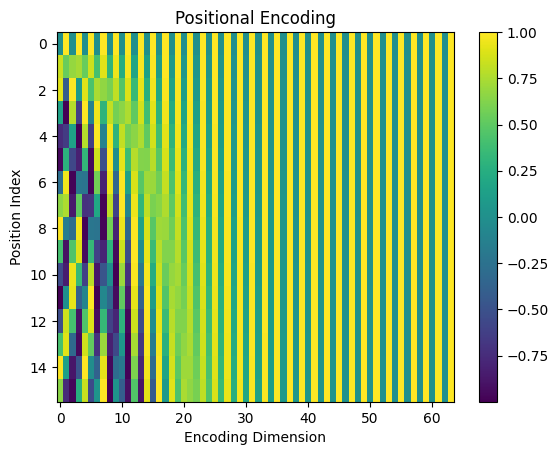

In [20]:
# Illustration Purpose Only
# 位置向量可视化
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [21]:
# Add positional encoding into the input embedding vector
# 位置向量信息加词向量信息
input_embedding_x = x_batch_embedding + position_encoding_lookup_table # [4, 16, 64] [batch_size, context_length, d_model]
input_embedding_y = y_batch_embedding + position_encoding_lookup_table
pd.DataFrame(input_embedding_x[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.429120,-1.098844,-0.080055,0.836584,0.097882,0.980574,0.062618,0.360595,0.813314,0.613190,...,0.514942,1.685295,-1.593473,0.102939,0.781685,1.033012,-0.979184,3.759405,-0.444012,1.352421
1,0.018790,0.041842,3.177333,-0.702859,0.563952,-0.182099,1.372611,-0.911021,1.837427,1.681453,...,-0.875306,0.824614,-0.422385,2.820027,-2.173537,0.135974,-0.087279,1.809196,0.506296,0.403991
2,-0.576147,-0.303029,2.193660,1.824779,0.920853,1.456270,0.364062,-0.206519,1.391069,1.158788,...,-0.786858,1.349099,-0.490047,0.910295,1.223883,0.198992,0.311965,2.375616,0.532111,-0.678781
3,0.295440,-0.426397,1.115912,-1.218402,1.924390,-0.673319,2.044948,0.238281,2.098096,-1.127724,...,-1.486702,2.408601,-0.583126,0.526450,-2.539209,1.725508,1.368430,2.712548,1.440396,1.654690
4,-0.400659,-0.814092,0.925708,-0.535223,0.532417,-0.747264,1.392377,-1.996841,-0.045985,-0.339367,...,1.559229,-0.204050,-0.379676,1.723722,-1.389095,0.585343,1.298879,1.136980,-0.051079,1.411836
5,-0.477125,-0.263306,0.474095,-0.029578,0.631249,-0.206443,-0.208251,0.250564,0.195159,0.399324,...,0.980674,0.067069,0.445831,1.771974,-0.433033,0.027834,0.239987,2.753690,-2.225085,1.727836
6,-1.018672,2.389402,-1.682434,-0.189376,-1.058081,-1.543334,-1.909576,-0.288463,-0.908153,-0.279262,...,-2.123044,1.007482,0.495677,1.347763,-0.637191,1.095827,1.579314,1.295505,1.036067,1.370119
7,1.942410,1.108056,-0.693313,0.444062,0.177045,1.574290,-0.632895,-0.715188,1.002453,-1.348007,...,0.087191,0.936511,0.425900,1.168335,-1.604715,0.700976,0.159343,0.372097,0.489373,1.059628
8,2.666086,-1.203837,0.964584,1.146727,-1.530863,-1.107102,0.636139,-1.129125,0.737536,-1.577059,...,0.331791,1.838058,0.931352,1.676619,0.851436,1.552475,0.855349,1.395033,1.029566,0.975857
9,0.250436,0.227683,0.641056,1.206820,-2.560165,0.546217,-1.037999,0.263772,-0.730955,-2.219368,...,0.553397,1.151931,-0.860009,-0.207291,0.079370,1.864052,0.299668,1.007171,0.696650,1.275786


In [22]:
# Prepare Query, Key, Value for Multi-head Attention
X = input_embedding_x
query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]
query.shape

torch.Size([4, 16, 64])

In [24]:
# Define Query, Key, Value weight matrices
Wq = nn.Linear(d_model, d_model)
Wk = nn.Linear(d_model, d_model)
Wv = nn.Linear(d_model, d_model)

Q = Wq(query) #[4, 16, 64]
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

K = Wk(key) #[4, 16, 64]
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

V = Wv(value) #[4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

# print(torch.round(Q[0] * 100) / 100)

# 大Q是 [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]
# 这个则是遍历每个4头, 16维度
qqq = Q.detach().cpu().numpy()
for qs in qqq:
    for qss in qs:
        print(pd.DataFrame(qss))

print(Q.shape) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

         0         1         2         3         4         5         6   \
0  0.657414  0.872972 -0.231637 -0.584895 -0.489887 -0.142829 -0.106594   
1 -0.124199  1.178569 -0.101906  0.637302  0.000999  1.117411  1.267956   
2  0.775449  0.071916  1.149693 -1.492254 -0.673091  0.024734  1.128383   
3  0.241492  1.089979 -0.597753 -0.264746 -0.314929 -0.982105 -0.681241   

         7         8         9         10        11        12        13  \
0  0.505478 -0.196674 -0.017201  0.915968  0.753584 -0.841393 -1.183698   
1 -0.680977 -0.691312  0.728115 -0.493498 -0.615478 -1.417619 -1.006107   
2  1.130208 -0.178143  1.303577  0.664138 -1.168537 -0.011217 -0.904679   
3  0.630806 -0.527820  0.245860  0.496230 -0.462229  0.840666  0.527826   

         14        15  
0 -0.998909  0.676501  
1 -0.769674  0.406986  
2 -0.813052  0.166687  
3 -0.346225  0.624200  
         0         1         2         3         4         5         6   \
0  0.991776  0.800381 -1.234527  0.953837 -0.856924 -

In [25]:
# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
# 变成可以相乘的格式 [4, 4, 16, 16]
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.783758,-0.800027,0.097881,0.558044,0.093322,0.419487,-0.020636,-0.081276,0.854902,0.317501,1.011674,0.339946,0.099766,0.104337,0.381969,0.267121
1,0.417098,-0.083625,0.217405,0.305349,-0.068498,-0.217199,-0.124063,-1.098769,0.348238,0.026739,0.516757,0.080695,-0.297324,-0.216589,-0.022026,0.736859
2,0.633160,0.010264,0.782662,1.142204,-0.402291,0.363256,0.300339,-0.006741,0.984101,-0.170208,0.492895,-0.212691,-0.335634,-0.192375,-0.685408,0.789993
3,-0.490519,-1.555948,-0.331149,-1.385174,-0.734437,-0.550090,0.339611,-0.554787,-0.238882,0.097718,-0.547627,0.643054,-0.845279,-0.108797,-0.382914,0.214394
4,0.039042,-0.757775,0.213303,-1.276437,-0.236787,0.174761,-0.267179,-0.480166,0.456374,0.186741,0.330652,-0.250169,-1.109757,0.204027,-0.377855,0.590378
5,0.149632,-0.165684,0.003635,-0.542982,-0.290855,0.217865,-0.623345,-0.213117,0.423507,-0.146518,0.424011,-0.531105,-0.806474,0.190945,-0.359318,0.150702
6,-1.072544,-0.447136,-0.715886,-0.809838,-1.023454,-1.281885,-0.260637,-0.694678,-1.971356,-0.397254,-1.338733,-0.208409,-0.803399,-0.103625,-0.694321,-0.627801
7,-0.067681,-0.016418,-0.142634,0.880122,-0.278064,-0.381162,-0.481150,0.034148,-0.106365,-0.082271,-0.043824,0.137786,-0.465169,0.063286,-0.201281,-0.256657
8,0.275872,-0.657136,0.621649,0.443326,-0.647256,0.138881,0.273014,-0.072337,0.557288,-0.134265,-0.217485,-0.223327,-0.892498,-0.540514,-1.084838,0.833426
9,-1.154914,-1.060322,0.070129,-2.005704,-0.340879,0.006452,-0.516524,-0.576408,-0.471464,-0.541664,-0.626952,-0.146389,-0.956262,-0.204767,-0.767421,0.113819


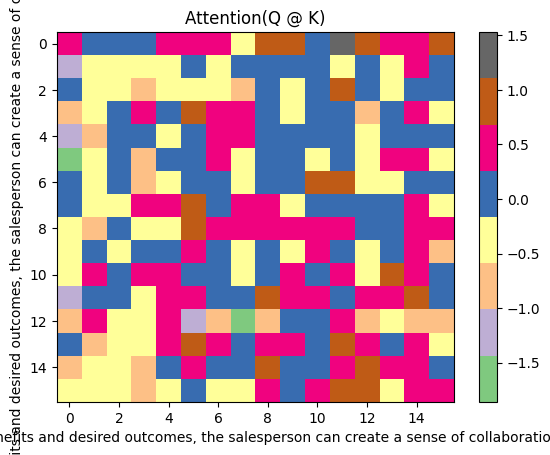

In [26]:
# Calculate the attention score  最后是 4batch 4头 16乘16的
# torch.matmul是乘法的意思； K.transpose(-2, -1) 转置
# math.sqrt(d_model // num_heads) 是根号下dKEY
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") #plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.827912,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,1.123528,0.464093,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,1.040623,0.605709,0.119165,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.900045,0.596818,0.359724,0.836026,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,1.061119,1.158659,0.633724,-0.320907,0.383561,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,0.071058,0.273445,0.044782,0.250272,-0.114290,0.121239,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,0.897961,1.322748,0.553525,0.079147,0.502846,-0.506932,0.223247,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,0.025299,0.779429,0.627483,-0.354743,0.218848,-0.055096,0.297431,-0.119230,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,0.529123,-0.196815,0.232964,0.031045,0.214278,-0.328799,-0.685732,0.060671,0.237945,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,0.935247,0.690427,0.511019,1.063499,0.504674,-0.227777,-0.035515,-0.006277,0.174739,0.899135,-inf,-inf,-inf,-inf,-inf,-inf


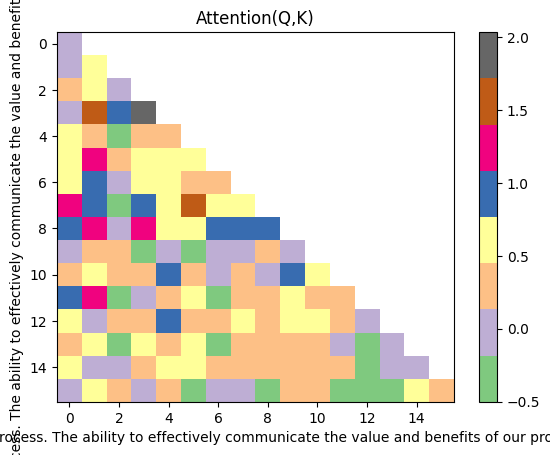

In [27]:
# Apply Mask to attention scores
# torch.ones(attention_score.shape[-2:]):   创建一个形状与 attention_score 的最后两个维度相同的全1张量。
# torch.triu(..., diagonal=1):    从上一步创建的全1张量中，生成一个上三角矩阵。
#.bool(): 将上三角矩阵转换为布尔值（True/False）形式。1会变为True，0会变为False
# attention_score.masked_fill(..., float('-inf')):
# masked_fill 函数会根据布尔掩码的值替换 attention_score 中的元素。在布尔掩码中，所有为True的元素对应的 attention_score 的位置将被替换为 -inf（负无穷大），而为False的元素保持不变
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]), diagonal=1).bool(), float('-inf'))#[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

In [27]:
# Softmax the attention score
# 特别注意dim=-1 意思是处理每个最后一个维度成softmax格式。（对于每一行都操作，每个词对其它16个词的关注度）
attention_score = torch.softmax(attention_score, dim=-1) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.095721,0.019642,0.048210,0.076380,0.047990,0.066498,0.042822,0.040302,0.102779,0.060050,0.120223,0.061413,0.048301,0.048522,0.064049,0.057100
1,0.085196,0.051637,0.069774,0.076189,0.052424,0.045180,0.049590,0.018711,0.079527,0.057662,0.094125,0.060859,0.041702,0.045208,0.054918,0.117298
2,0.082335,0.044164,0.095612,0.136981,0.029234,0.062859,0.059026,0.043419,0.116949,0.036871,0.071560,0.035337,0.031249,0.036063,0.022026,0.096316
3,0.049201,0.016954,0.057702,0.020111,0.038552,0.046356,0.112848,0.046138,0.063279,0.088602,0.046470,0.152855,0.034507,0.072070,0.054791,0.099567
4,0.067565,0.030456,0.080427,0.018131,0.051278,0.077386,0.049743,0.040201,0.102557,0.078319,0.090441,0.050596,0.021419,0.079685,0.044531,0.117264
5,0.077669,0.056664,0.067118,0.038855,0.049997,0.083153,0.035855,0.054039,0.102139,0.057760,0.102190,0.039319,0.029855,0.080945,0.046689,0.077752
6,0.042291,0.079043,0.060415,0.054998,0.044419,0.034303,0.095249,0.061710,0.017215,0.083086,0.032408,0.100356,0.055353,0.111442,0.061732,0.065979
7,0.060297,0.063468,0.055943,0.155568,0.048857,0.044071,0.039877,0.066760,0.058009,0.059423,0.061753,0.074050,0.040520,0.068734,0.052756,0.049914
8,0.077381,0.030439,0.109347,0.091487,0.030742,0.067475,0.077160,0.054627,0.102531,0.051347,0.047247,0.046972,0.024056,0.034205,0.019847,0.135138
9,0.031096,0.034181,0.105861,0.013280,0.070184,0.099330,0.058878,0.055456,0.061592,0.057417,0.052723,0.085252,0.037930,0.080417,0.045813,0.110589


In [29]:
# Calculate the V attention output
print(attention_score.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(V.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
A = torch.matmul(attention_score, V) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
print(A.shape)

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [31]:
# Concatenate the attention output
# 并行计算完补全头 （合并）
A = A.transpose(1, 2) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

# 背下来吧
A = A.reshape(batch_size, -1, d_model) # [4, 16, 64] [batch_size, context_length, d_model]
A.shape

torch.Size([4, 16, 64])

In [32]:
# Define the output weight matrix
Wo = nn.Linear(d_model, d_model)
output = Wo(A) # [4, 16, 64] [batch_size, context_length, d_model]
print(output.shape)
pd.DataFrame(output[0].detach().cpu().numpy())

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.200058,0.417928,0.436654,0.394750,-0.442014,-0.127205,-0.056222,-0.280285,0.176070,0.530091,...,0.203488,-0.076491,0.130021,-0.396635,0.123933,-0.358833,-0.072565,0.106055,-0.128938,-0.348600
1,-0.740793,-0.340264,-0.708956,-0.477954,0.102357,-0.095372,-0.079068,0.155354,0.157295,-0.052038,...,-0.778702,-0.102471,-0.091548,0.435446,-0.360780,0.497173,-0.165212,0.000560,-0.323989,-0.083656
2,0.286138,0.125765,0.365248,0.392788,0.060482,0.118448,0.091294,-0.294131,0.111121,0.549082,...,0.099660,0.029980,-0.210557,-0.451184,-0.158488,-0.128480,0.337580,-0.309091,-0.114176,-0.083779
3,-0.118934,-0.136915,-0.177407,-0.009172,0.329628,0.122636,0.047678,-0.042957,0.086823,0.278188,...,-0.248977,-0.021408,-0.211381,-0.036873,-0.309639,0.091590,0.083480,-0.182640,-0.170757,-0.059678
4,-0.369929,0.281683,-0.001643,0.047538,-0.300938,-0.188866,-0.151915,-0.057755,0.061328,0.098737,...,0.034151,0.111889,0.178510,-0.124637,0.041168,-0.269199,-0.182929,0.102896,-0.059679,-0.211507
5,-0.089483,-0.041704,-0.059797,0.101612,-0.081325,-0.029403,-0.055197,-0.070895,-0.019638,0.068395,...,-0.045305,0.036177,0.034833,-0.086957,-0.127944,-0.094595,-0.134099,0.025996,-0.044967,0.011276
6,0.372455,0.153272,0.241736,0.407337,-0.089135,-0.081300,-0.268509,0.172023,-0.006295,0.076823,...,0.352132,0.296114,0.055923,-0.246443,0.148543,-0.625919,-0.643657,0.310350,0.338592,-0.259842
7,-0.280772,0.226248,0.071996,0.186831,-0.026164,-0.031896,0.139680,-0.125537,0.099027,0.344366,...,-0.060728,-0.019992,0.011582,-0.180040,-0.096258,-0.106743,0.250441,-0.143498,-0.218418,-0.189080
8,-0.663884,0.396451,0.079785,0.004636,-0.542975,-0.415546,-0.326083,0.028062,0.189859,0.147484,...,-0.088276,-0.048041,0.330833,-0.004918,0.204871,-0.286883,-0.464410,0.394802,0.004047,-0.411216
9,0.442745,0.249657,0.461647,0.497740,-0.121210,-0.030912,-0.266550,0.105766,-0.049755,0.243383,...,0.476066,0.170916,-0.006310,-0.453460,0.104662,-0.647484,-0.503370,0.271523,0.283850,-0.321230


In [33]:
# Add residual connection
output = output + X

In [34]:
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output_layernorm = layer_norm(output)

In [40]:
# Define Feed Forward Network
# 扩展
# Relu
# 收缩
output = nn.Linear(d_model, d_model * 4)(output_layernorm)
output = nn.ReLU()(output)
output = nn.Linear(d_model * 4, d_model)(output)
output = torch.dropout(output, p=dropout, train=True)

In [44]:
# Add residual connection & layerNorm (last time in a Transformer block)
output = output + output_layernorm
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [45]:
# Until here, we finished a Transformer block,
# 这只是一个block 真正Transformers有多次循环Block

# We actually should pack the above Transformer block code into a call and
# repeat the steps for num_layers times
# but this jupyter notebook is purely for illustration purpose, so we'll skip it:
# for _ in range(num_layers):
#   do loop for each transformer block

In [46]:
# Apply the final linear layer to get the logits

logits = nn.Linear(d_model, max_token_value+1)(output)
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,-0.271341,-0.665651,0.555655,0.751122,0.428481,0.343952,0.291792,-0.462851,0.920529,-0.541936,...,0.440426,-0.115321,0.705279,0.234207,-0.370006,0.419876,0.690633,-0.448361,0.149523,0.081283
1,-0.451516,0.301818,-0.954615,-0.154411,-0.224893,1.036211,0.662409,0.285657,-0.111492,-0.204154,...,-0.490137,-0.231061,1.011236,-0.667682,0.363966,-0.261142,-0.903152,0.085444,-0.863552,-0.452057
2,-1.421438,0.238842,-0.146230,0.498800,0.685048,0.164292,1.030940,-0.106637,0.881313,-0.195736,...,0.412753,0.341391,0.227449,0.066317,-0.176936,-0.537784,-0.099183,-0.495768,0.342679,0.457300
3,0.040004,0.370197,-0.988124,-0.253688,-0.596069,0.526259,-0.622505,0.379928,0.610429,-0.510875,...,0.137397,-0.972376,0.150781,-0.108121,-0.121959,-0.355384,-0.678154,-0.491937,-0.595723,0.468433
4,-0.968015,0.182286,-0.452614,0.157622,-0.448301,1.248778,0.297785,0.258606,0.083124,0.291032,...,0.444832,0.461823,0.176869,-0.378194,1.447979,0.033490,0.173102,0.016784,-0.293797,0.597699
5,-0.383180,0.311767,-0.134690,0.713300,-0.924216,0.850934,0.095244,-0.631499,0.031517,0.114225,...,-0.742207,-0.562995,0.561332,-1.068173,1.320460,-0.143849,0.057010,0.823357,-0.368982,-0.304534
6,0.790099,0.090132,-0.071629,-0.404748,-0.570616,0.540904,-0.408270,0.071845,-1.075959,-0.318294,...,-0.629057,0.140053,-0.153314,0.063926,-0.160519,-0.861309,-0.055360,-0.261961,-0.660986,-0.119845
7,-0.371275,0.386982,-0.629513,0.580910,0.242814,-0.660384,-0.354821,1.030257,0.597469,0.755395,...,-0.333432,0.158882,0.219124,0.849916,0.320014,0.424316,-0.406919,0.557709,-0.441013,0.179806
8,-0.478246,0.668997,-0.015115,0.497310,-0.593670,0.828148,-0.848668,-0.379666,-0.477059,-0.355724,...,0.725008,-0.754231,0.333854,0.062175,0.568252,0.417724,-0.407502,-0.294843,-0.572325,0.390218
9,0.124899,-0.061149,-0.592110,-0.129698,0.146690,0.072172,-0.553916,-0.112682,0.240458,-1.060465,...,1.012543,0.776316,-0.353443,0.593838,-0.556906,0.143216,0.754400,0.093462,0.549536,0.899232


In [47]:
# Get the probabilities 
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)
pd.DataFrame(probabilities[0].detach().cpu().numpy())


,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.000006,0.000004,0.000015,0.000018,0.000013,0.000012,0.000011,0.000005,0.000021,0.000005,...,0.000013,0.000008,0.000017,0.000011,0.000006,0.000013,0.000017,0.000005,0.000010,0.000009
1,0.000005,0.000011,0.000003,0.000007,0.000007,0.000024,0.000016,0.000011,0.000008,0.000007,...,0.000005,0.000007,0.000023,0.000004,0.000012,0.000006,0.000003,0.000009,0.000004,0.000005
2,0.000002,0.000011,0.000007,0.000014,0.000017,0.000010,0.000024,0.000008,0.000020,0.000007,...,0.000013,0.000012,0.000011,0.000009,0.000007,0.000005,0.000008,0.000005,0.000012,0.000013
3,0.000009,0.000012,0.000003,0.000007,0.000005,0.000014,0.000005,0.000012,0.000016,0.000005,...,0.000010,0.000003,0.000010,0.000008,0.000007,0.000006,0.000004,0.000005,0.000005,0.000013
4,0.000003,0.000010,0.000005,0.000010,0.000005,0.000029,0.000011,0.000011,0.000009,0.000011,...,0.000013,0.000013,0.000010,0.000006,0.000036,0.000009,0.000010,0.000009,0.000006,0.000015
5,0.000006,0.000012,0.000007,0.000017,0.000003,0.000020,0.000009,0.000004,0.000009,0.000009,...,0.000004,0.000005,0.000015,0.000003,0.000032,0.000007,0.000009,0.000019,0.000006,0.000006
6,0.000019,0.000009,0.000008,0.000006,0.000005,0.000015,0.000006,0.000009,0.000003,0.000006,...,0.000005,0.000010,0.000007,0.000009,0.000007,0.000004,0.000008,0.000006,0.000004,0.000007
7,0.000006,0.000012,0.000004,0.000015,0.000011,0.000004,0.000006,0.000024,0.000015,0.000018,...,0.000006,0.000010,0.000010,0.000020,0.000012,0.000013,0.000006,0.000015,0.000005,0.000010
8,0.000005,0.000016,0.000008,0.000014,0.000005,0.000019,0.000004,0.000006,0.000005,0.000006,...,0.000017,0.000004,0.000012,0.000009,0.000015,0.000013,0.000006,0.000006,0.000005,0.000012
9,0.000010,0.000008,0.000005,0.000007,0.000010,0.000009,0.000005,0.000008,0.000011,0.000003,...,0.000023,0.000018,0.000006,0.000015,0.000005,0.000010,0.000018,0.000009,0.000015,0.000021


In [48]:
# Let's see the predicted token and it's original English word
# logits[0,0]: 取第一个batch的第一个位置的预测向量（包含词表大小个数的分数）
# torch.argmax(): 找出分数最高的位置（即最可能的token的索引）
# .item(): 将tensor转换为Python的标量数值

predicted_index = torch.argmax(logits[0,0]).item()
# 将预测出的token索引转换回实际的文本
encoding.decode([predicted_index])

' rapp'

In [49]:
# Let's see the original input sentence
# encoding.decode(x_batch[0].tolist())
# x_batch[0]: 取第一个batch的输入序列
# .tolist(): 将tensor转换为Python列表
# encoding.decode(): 将token索引序列转换回原始文本
encoding.decode(x_batch[0].tolist())

' mutual benefits and desired outcomes, the salesperson can create a sense of collaboration and'

In [ ]:
# Looks like the predicted token "Catholics" is not the correct prediction token to the original sentence, because we only did one training loop and barely trained nothing.
# But this is the basic idea of how the Transformer works.
# We'll continue to train the model in the next notebook and wrap the above code into a class.
# https://waylandzhang.github.io/en/let-s-code-llm.html